In [1]:
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

zip_path = '/content/Solutions Data Project.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    print(zip_ref.namelist())

    target_file = 'Solutions Data Project/Solutions Data Project - Data.csv'

    with zip_ref.open(target_file) as file:
        df = pd.read_csv(file)

print(df.head())

['Solutions Data Project/Solutions Data Project - Prompt.docx', 'Solutions Data Project/Solutions Data Project - Data.csv']
   game_id        date  season  batter_id             batter bats  pitcher_id  \
0   744801  2024-09-15    2024     660821      Jesus Sanchez    L      669022   
1   744815  2024-08-22    2024     669911     Michael Toglia    R      571578   
2   744819  2024-08-08    2024     592192         Mark Canha    R      571882   
3   744819  2024-08-08    2024     666464  Jerar Encarnacion    R      687792   
4   744821  2024-08-05    2024     656305       Matt Chapman    R      674285   

           pitcher throws  inning half_inning  tto  pitch_num  balls  strikes  \
0   MacKenzie Gore      L       1         Top  1st          6      2        2   
1   Patrick Corbin      L       6         Top  3rd          1      0        0   
2        Derek Law      R       8         Top  1st          5      2        2   
3          DJ Herz      L       1         Top  1st          1    

In [2]:
# Quick look
print(df.shape)
print(df.columns)
print(df.dtypes)
print(df.head())


print(df['pitch_type'].unique())

(3108206, 36)
Index(['game_id', 'date', 'season', 'batter_id', 'batter', 'bats',
       'pitcher_id', 'pitcher', 'throws', 'inning', 'half_inning', 'tto',
       'pitch_num', 'balls', 'strikes', 'outs', 'pitch_type', 'release_velo',
       'spin_rate', 'spin_direction', 'break_x', 'break_z', 'induced_break_z',
       'location_x', 'location_z', 'release_x', 'release_z', 'extension',
       'haa', 'vaa', 'hra', 'vra', 'exit_velo', 'launch_angle', 'spray_angle',
       'hit_spin_rate'],
      dtype='object')
game_id              int64
date                object
season               int64
batter_id            int64
batter              object
bats                object
pitcher_id           int64
pitcher             object
throws              object
inning               int64
half_inning         object
tto                 object
pitch_num            int64
balls                int64
strikes              int64
outs                 int64
pitch_type          object
release_velo       float64
sp

In [3]:
print(df['pitcher_id'].nunique())
print(sum(df['pitch_type'] == 'KN'))

#guess I'll keep the knuckleballers

1664
1333


In [4]:
# dropping non competitive pitches
df = df[df['release_velo'] >= 60]

In [5]:
# Define fastball pitch types
fastballs = ['FF', 'SI', 'CT']
breaking_balls = ['SL', 'CB', 'SW', 'SV', 'CH', 'SP', 'KN']

fastball_df = df[df['pitch_type'].isin(fastballs)].copy()

# Group by pitcher-season and pitch_type to compute average velo for each fastball
fb_by_type = (
    fastball_df
    .groupby(['pitcher_id', 'season', 'pitch_type'])['release_velo']
    .mean()
    .reset_index()
)

# Select the fastest fastball by pitcher-season
fb_primary = (
    fb_by_type
    .sort_values(['pitcher_id', 'season', 'release_velo'], ascending=[True, True, False])
    .drop_duplicates(subset=['pitcher_id', 'season'], keep='first')
    .rename(columns={'release_velo': 'avg_fastball_velocity', 'pitch_type': 'primary_fastball_type'})
)

#dropping position player pitching while trying to keep tyler rogers, slowest actual pitcher
tyler_id = df[df['pitcher'] == 'Tyler Rogers']['pitcher_id'].iloc[0]

tyler_fb_velo = fb_primary[fb_primary['pitcher_id'] == tyler_id]['avg_fastball_velocity']
print(tyler_fb_velo)


fb_primary = fb_primary[fb_primary['avg_fastball_velocity'] >= 82][['pitcher_id', 'season', 'avg_fastball_velocity', 'primary_fastball_type']]

print(fb_primary)

4328    82.781634
4330    82.811360
4332    83.518425
4334    82.926394
4335    82.702488
Name: avg_fastball_velocity, dtype: float64
      pitcher_id  season  avg_fastball_velocity primary_fastball_type
2         424144    2020              89.961188                    SI
4         424144    2021              89.207681                    SI
6         424144    2022              88.369821                    SI
9         425794    2020              89.276400                    SI
12        425794    2021              89.055520                    SI
...          ...     ...                    ...                   ...
7725      800049    2024              94.573242                    FF
7728      805673    2024              94.909021                    FF
7729      806185    2024              95.775722                    FF
7731      808967    2024              95.486165                    FF
7733      814005    2024              93.361433                    FF

[4000 rows x 4 columns]


In [6]:
# Drop old velocity column if it exists
if 'avg_fastball_velocity' in df.columns:
    df = df.drop(columns=['avg_fastball_velocity'])

if 'primary_fastball_type' in df.columns:
    df = df.drop(columns=['primary_fastball_type'])


df = df.merge(fb_primary, on=['pitcher_id', 'season'], how='left')

df_breaking = df[df['pitch_type'].isin(breaking_balls)].copy()


# Create target variable
df_breaking['velocity_gap'] = df_breaking['release_velo'] - df_breaking['avg_fastball_velocity']

print(df_breaking[['pitcher_id', 'season', 'pitch_type', 'release_velo', 'avg_fastball_velocity', 'velocity_gap']])

df_breaking

         pitcher_id  season pitch_type  release_velo  avg_fastball_velocity  \
0            669022    2024         CB       85.0360              96.002728   
2            571882    2024         SL       86.8405              95.197707   
3            687792    2024         CH       83.3906              93.501114   
4            674285    2024         SL       88.7638              95.426023   
5            571578    2024         SL       79.3508              91.456099   
...             ...     ...        ...           ...                    ...   
3104886      613534    2020         SL       85.6433              93.322000   
3104887      613534    2020         SL       85.8004              93.322000   
3104888      613534    2020         SL       85.6784              93.322000   
3104889      657612    2020         SL       80.9345              91.410825   
3104890      572125    2020         SL       78.2622              91.331350   

         velocity_gap  
0          -10.966728  
2  

game_id        date  season  batter_id             batter bats  \
0         744801  2024-09-15    2024     660821      Jesus Sanchez    L   
2         744819  2024-08-08    2024     592192         Mark Canha    R   
3         744819  2024-08-08    2024     666464  Jerar Encarnacion    R   
4         744821  2024-08-05    2024     656305       Matt Chapman    R   
5         744827  2024-07-25    2024     701538    Jackson Merrill    L   
...          ...         ...     ...        ...                ...  ...   
3104886   631002  2020-09-27    2020     543063   Brandon Crawford    L   
3104887   631002  2020-09-27    2020     663698          Joey Bart    R   
3104888   631002  2020-09-27    2020     663698          Joey Bart    R   
3104889   631002  2020-09-27    2020     573262   Mike Yastrzemski    L   
3104890   631002  2020-09-27    2020     630105   Jake Cronenworth    L   

         pitcher_id          pitcher throws  inning half_inning  tto  \
0            669022   MacKenzie Gore      L       1         Top  1st   
2            571882        Derek Law      R       8         Top  1st   
3            687792          DJ Herz      L       1         Top  1st   
4            674285  Eduardo Salazar      R       8         Top  1st   
5            571578   Patrick Corbin      L       4         Top  2nd   
...             ...              ...    ...     ...         ...  ...   
3104886      613534     Austin Adams      R       7      Bottom  1st   
3104887      613534     Austin Adams      R       7      Bottom  1st   
3104888      613534     Austin Adams      R       7      Bottom  1st   
3104889      657612         Tim Hill      L       7      Bottom  1st   
3104890      572125       Sam Selman      L       8         Top  1st   

         pitch_num  balls  strikes  outs pitch_type  release_velo  spin_rate  \
0                6      2        2     2         CB       85.0360  2403.1722   
2                5      2        2     0         SL       86.8405  2259.2908   
3                1      0        0     2         CH       83.3906  2120.8318   
4                3      1        1     0         SL       88.7638  2157.9990   
5                1      0        0     1         SL       79.3508  2195.1963   
...            ...    ...      ...   ...        ...           ...        ...   
3104886          3      2        0     1         SL       85.6433  2874.1629   
3104887          1      0        0     1         SL       85.8004  3005.5961   
3104888          3      2        0     1         SL       85.6784  2834.9999   
3104889          1      0        0     2         SL       80.9345  1889.7062   
3104890          1      0        0     0         SL       78.2622  2385.0485   

         spin_direction  break_x  break_z  induced_break_z  location_x  \
0              347.8343  -1.0821 -45.5579          -7.9505      1.2690   
2              168.7031  -0.7406 -33.2313           2.4999     -0.2314   
3              103.2716 -16.2299 -35.8221           3.8464      0.7473   
4                6.5231  -5.3787 -31.8588           2.2482     -1.3051   
5              237.4493   5.3399 -42.0941           0.8750      0.3276   
...                 ...      ...      ...              ...         ...   
3104886         59.0491 -10.3790 -35.9505           0.9234      0.7064   
3104887        169.3748  -7.6460 -33.1564           3.3807     -1.1095   
3104888         39.0142  -6.0502 -35.5593           1.1381     -0.5164   
3104889        142.1739  -2.0248 -36.0079           5.7292     -0.6418   
3104890        284.3384  11.1403 -41.6825           2.5966     -0.5438   

         location_z  release_x  release_z  extension     haa      vaa     hra  \
0            0.2976    -1.4551     5.9136     6.8211  2.8782 -10.4744  3.0823   
2            1.1096     1.0864     6.6116     6.6238 -1.5109  -9.1573 -1.3716   
3            3.3321    -2.0395     5.8143     6.7368  1.4409  -6.2436  4.5211   
4            1.1357     1.9120     5.5856     6.7672 -4.0364  -7.8794

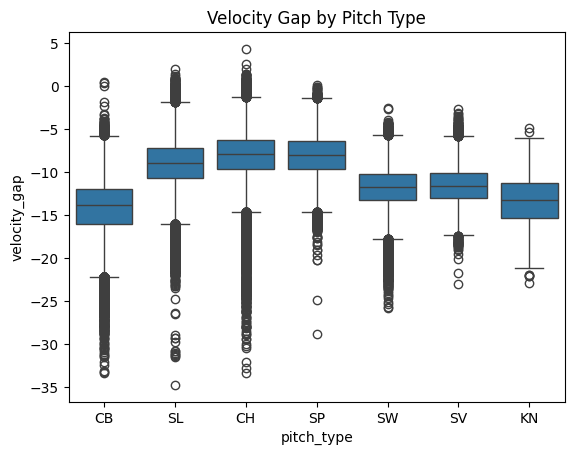

In [7]:
sns.boxplot(x='pitch_type', y='velocity_gap', data=df_breaking)
plt.title("Velocity Gap by Pitch Type")
plt.show()

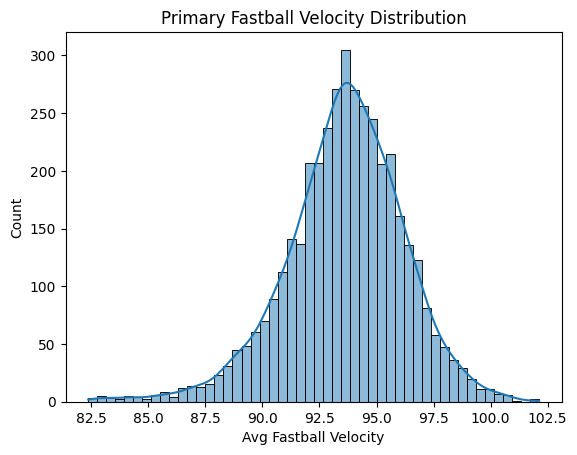

In [8]:
import seaborn as sns
sns.histplot(fb_primary['avg_fastball_velocity'], bins=50, kde=True)
plt.title("Primary Fastball Velocity Distribution")
plt.xlabel("Avg Fastball Velocity")
plt.show()

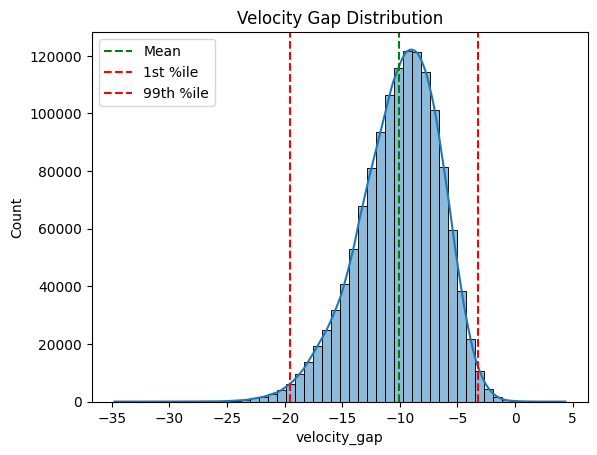

In [9]:
sns.histplot(df_breaking['velocity_gap'], bins=50, kde=True)
plt.axvline(df_breaking['velocity_gap'].mean(), color='green', linestyle='--', label='Mean')
plt.axvline(df_breaking['velocity_gap'].quantile(0.01), color='red', linestyle='--', label='1st %ile')
plt.axvline(df_breaking['velocity_gap'].quantile(0.99), color='red', linestyle='--', label='99th %ile')
plt.legend()
plt.title("Velocity Gap Distribution")
plt.show()

In [10]:
# Define outlier thresholds
high_thresh = df_breaking['velocity_gap'].quantile(0.99)
low_thresh = df_breaking['velocity_gap'].quantile(0.01)


gap_outliers = df_breaking[(df_breaking['velocity_gap'] > high_thresh) |
                           (df_breaking['velocity_gap'] < low_thresh)]

gap_outliers[['pitcher_id', 'pitcher', 'season', 'pitch_type', 'release_velo', 'avg_fastball_velocity', 'velocity_gap']].sort_values('velocity_gap')


pitcher_id           pitcher  season pitch_type  release_velo  \
1875333      656629    Michael Kopech    2023         SL       60.3973   
1032392      656302       Dylan Cease    2024         CH       63.4295   
2425830      506433        Yu Darvish    2020         CB       62.5447   
673791       571945     Miles Mikolas    2022         CB       60.2133   
1201842      663776  Patrick Sandoval    2022         CB       60.2709   
...             ...               ...     ...        ...           ...   
664977       543063  Brandon Crawford    2023         CH       85.4453   
675423       543063  Brandon Crawford    2023         CH       86.0015   
2451323      571666        Mike Fiers    2020         SL       90.2162   
1916494      425844      Zack Greinke    2020         CH       89.6912   
2922609      543063  Brandon Crawford    2023         CH       88.3755   

         avg_fastball_velocity  velocity_gap  
1875333              95.166311    -34.769011  
1032392              96.866113    -33.436613  
2425830              95.893405    -33.348705  
673791               93.502032    -33.288732  
1201842              93.434272    -33.163372  
...                        ...           ...  
664977               84.010078      1.435222  
675423               84.010078      1.991422  
2451323              88.180436      2.035764  
1916494              87.049274      2.641926  
2922609              84.010078      4.365422  

[27032 rows x 7 columns]

In [11]:
print(df_breaking.isna().sum().sort_values(ascending=False))

print(df_breaking[df_breaking['avg_fastball_velocity'].isna()])

#dropping these as they are the result of position players pitching without a primary fastball thrown

df_breaking = df_breaking[df_breaking['avg_fastball_velocity'].notna()]

print(df_breaking.isna().sum().sort_values(ascending=False))

hit_spin_rate            970312
exit_velo                949683
launch_angle             949316
spray_angle              949315
spin_direction             8500
spin_rate                  8500
extension                  2405
primary_fastball_type       810
avg_fastball_velocity       810
velocity_gap                810
break_x                       8
break_z                       2
season                        0
game_id                       0
date                          0
pitcher_id                    0
bats                          0
batter                        0
batter_id                     0
pitcher                       0
throws                        0
inning                        0
half_inning                   0
induced_break_z               0
outs                          0
pitch_type                    0
release_velo                  0
tto                           0
pitch_num                     0
balls                         0
strikes                       0
hra     

In [12]:
print(df_breaking[df_breaking['spin_rate'].isna()])
print(df_breaking[df_breaking['spin_direction'].isna()])
print(df_breaking[df_breaking['break_x'].isna()])
print(df_breaking[df_breaking['extension'].isna()])

#spin, extension, and break NAs look to be unfortunate no reads, will drop these because of large amounts of data and no clear pattern to see from why these are missing
#not going to end up using the hit information for this project so not unecessarily dropping good data elsewhere

df_breaking = df_breaking[df_breaking['break_z'].notna()]
df_breaking = df_breaking[df_breaking['spin_rate'].notna()]
df_breaking = df_breaking[df_breaking['spin_direction'].notna()]
df_breaking = df_breaking[df_breaking['break_x'].notna()]
df_breaking = df_breaking[df_breaking['extension'].notna()]

print(df_breaking.isna().sum().sort_values(ascending=False))

         game_id        date  season  batter_id              batter bats  \
64        745116  2024-03-28    2024     680700     Richie Palacios    L   
659       663022  2022-08-13    2022     571657         Kyle Farmer    R   
1280      745368  2024-09-08    2024     682617       Marco Luciano    R   
1368      745922  2024-04-19    2024     690993          Colt Keith    L   
1647      744832  2024-07-07    2024     575929   Willson Contreras    R   
...          ...         ...     ...        ...                 ...  ...   
3103819   631246  2020-09-25    2020     519058      Mike Moustakas    L   
3104045   631013  2020-09-25    2020     595777    Jurickson Profar    R   
3104340   631385  2020-09-26    2020     658668     Edward Olivares    R   
3104559   631338  2020-09-27    2020     621035        Chris Taylor    R   
3104878   631002  2020-09-27    2020     665487  Fernando Tatis Jr.    R   

         pitcher_id           pitcher throws  inning half_inning  tto  \
64           6

In [13]:
#want to check if time through order has any kind of velocity gap penalty

print(df_breaking['tto'].unique())

tto_mapping = {
    '1st': 1,
    '2nd': 2,
    '3rd': 3,
    '4+': 4
}

df_breaking['tto_ord'] = df_breaking['tto'].map(tto_mapping)

['1st' '2nd' '3rd' '4+']


In [14]:
#numeric variables to consider for correlation analysis
df_breaking.select_dtypes(exclude=['object']).columns.tolist()

['game_id',
 'season',
 'batter_id',
 'pitcher_id',
 'inning',
 'pitch_num',
 'balls',
 'strikes',
 'outs',
 'release_velo',
 'spin_rate',
 'spin_direction',
 'break_x',
 'break_z',
 'induced_break_z',
 'location_x',
 'location_z',
 'release_x',
 'release_z',
 'extension',
 'haa',
 'vaa',
 'hra',
 'vra',
 'exit_velo',
 'launch_angle',
 'spray_angle',
 'hit_spin_rate',
 'avg_fastball_velocity',
 'velocity_gap',
 'tto_ord']

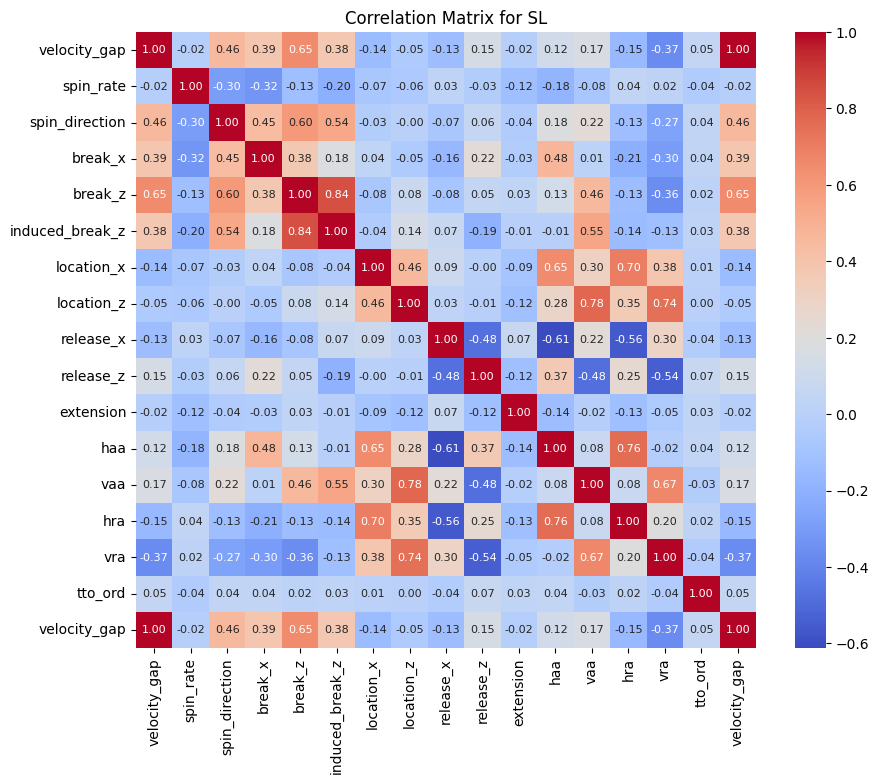

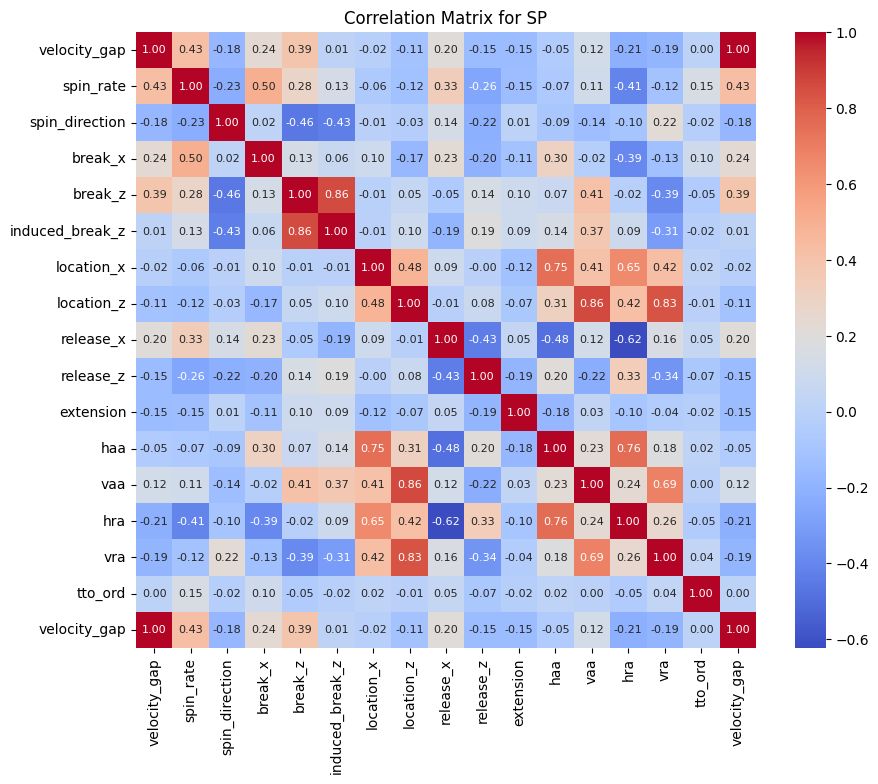

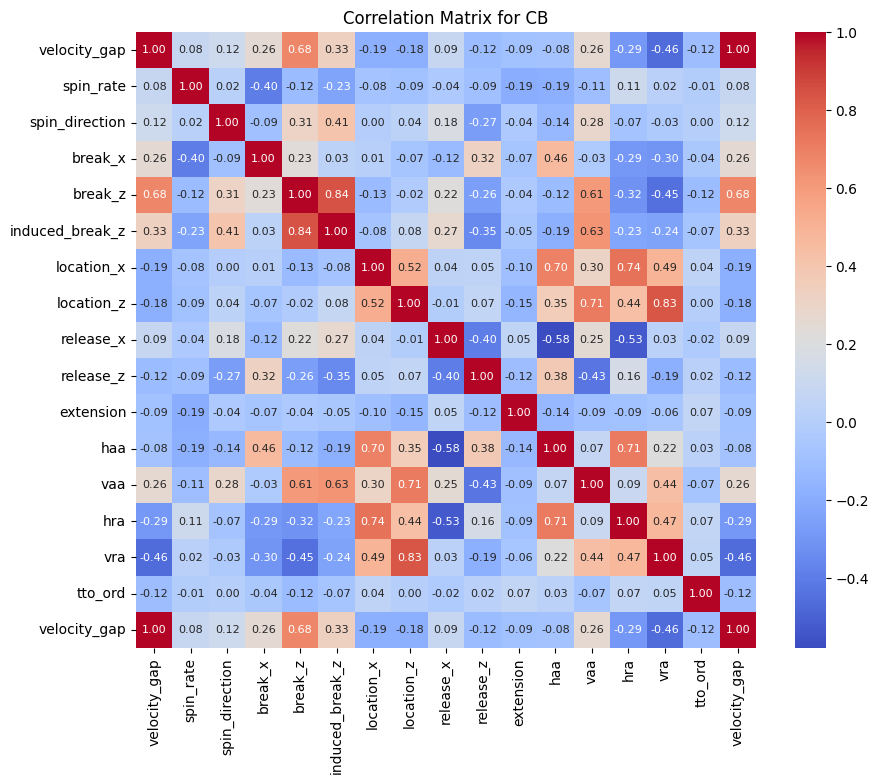

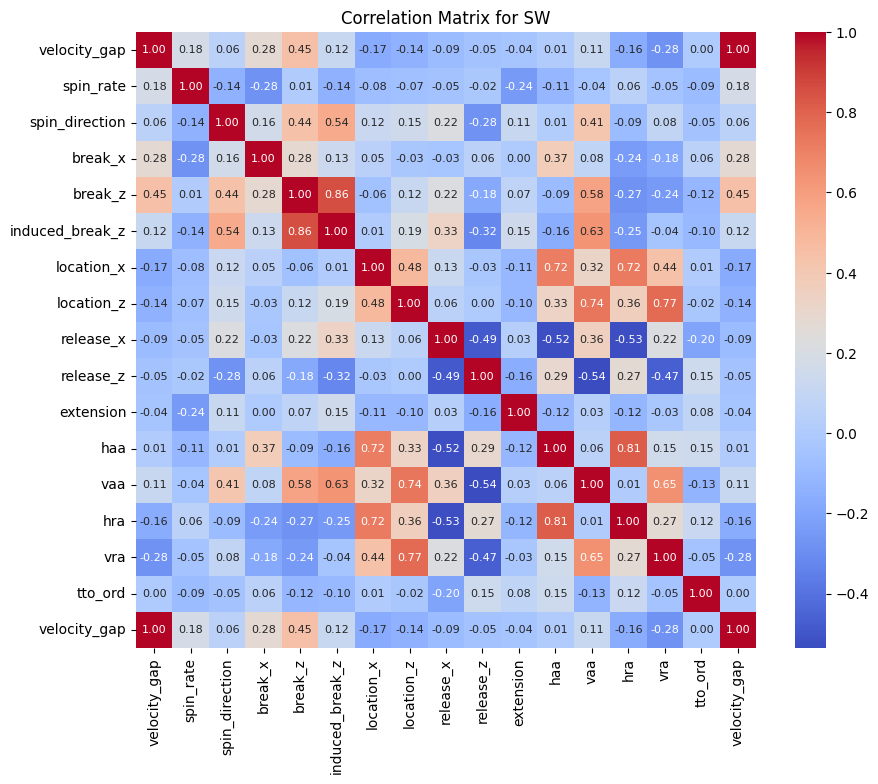

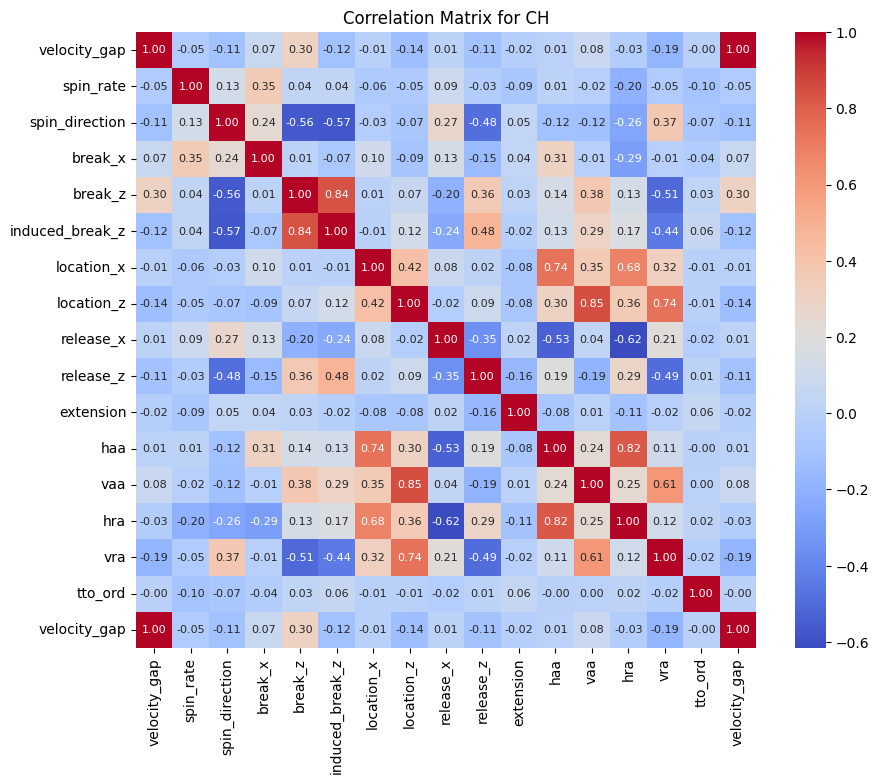

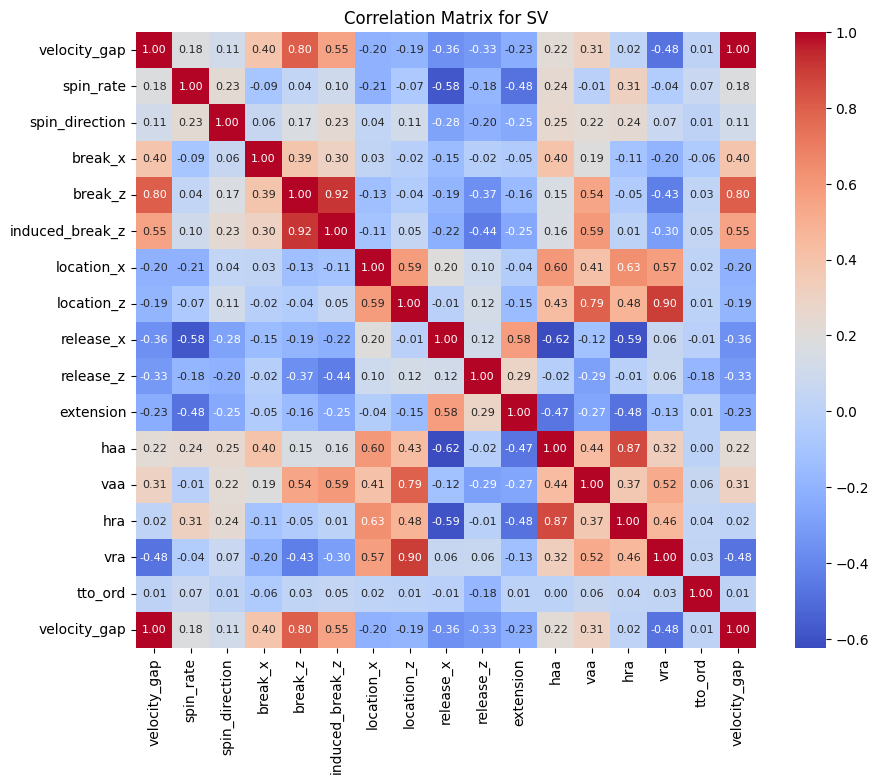

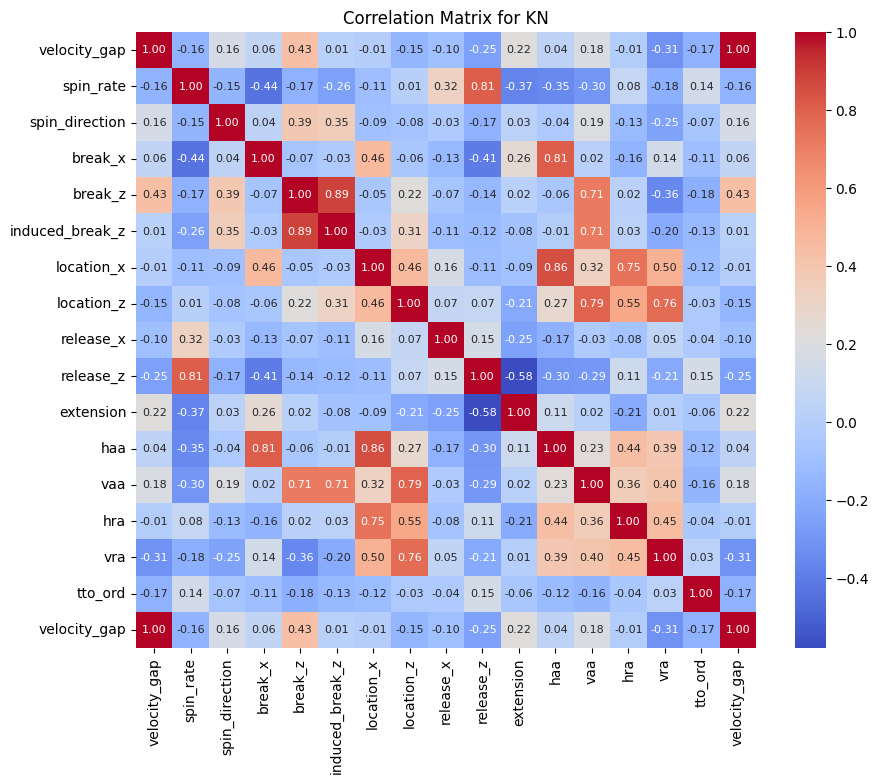

In [15]:
#numerical feature correlation matrix
#bucket by pitch type to avoid correlations only from pitch type
#handedness bucket to true examine HAA and HRA effects

righties = df_breaking[df_breaking['throws'] == 'R']

pitch_types = righties['pitch_type'].unique()

feature_cols = ['velocity_gap', 'spin_rate', 'spin_direction', 'break_x', 'break_z', 'induced_break_z', 'location_x',
                'location_z', 'release_x', 'release_z', 'extension', 'haa', 'vaa', 'hra',
                'vra', 'tto_ord']

for pitch in pitch_types:
    subset = righties[righties['pitch_type'] == pitch]
    corr = subset[feature_cols + ['velocity_gap']].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8})
    plt.title(f"Correlation Matrix for {pitch}")
    plt.show()

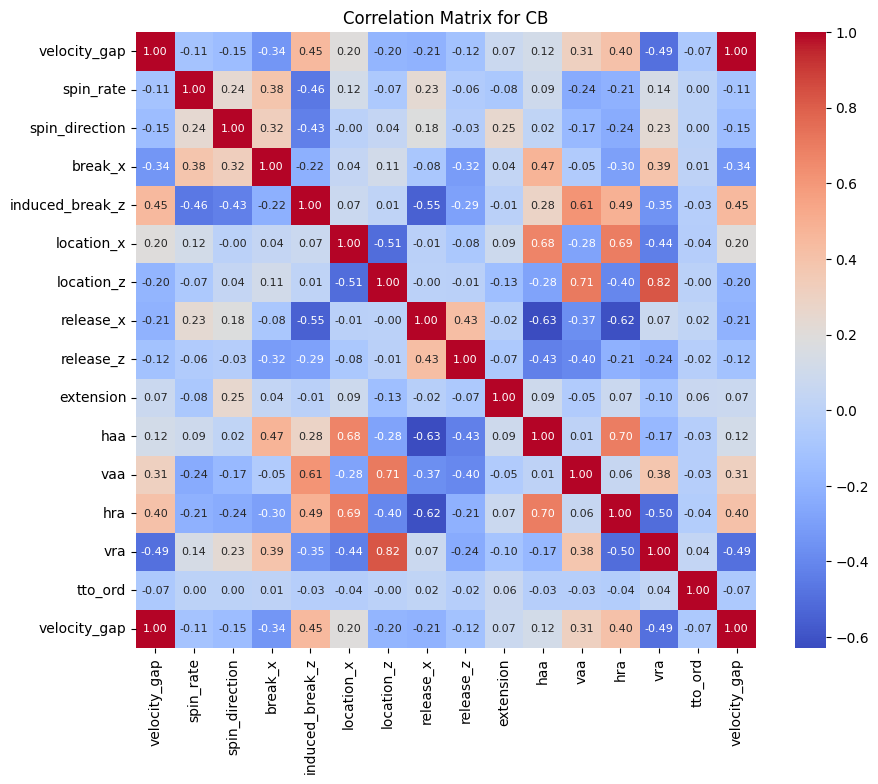

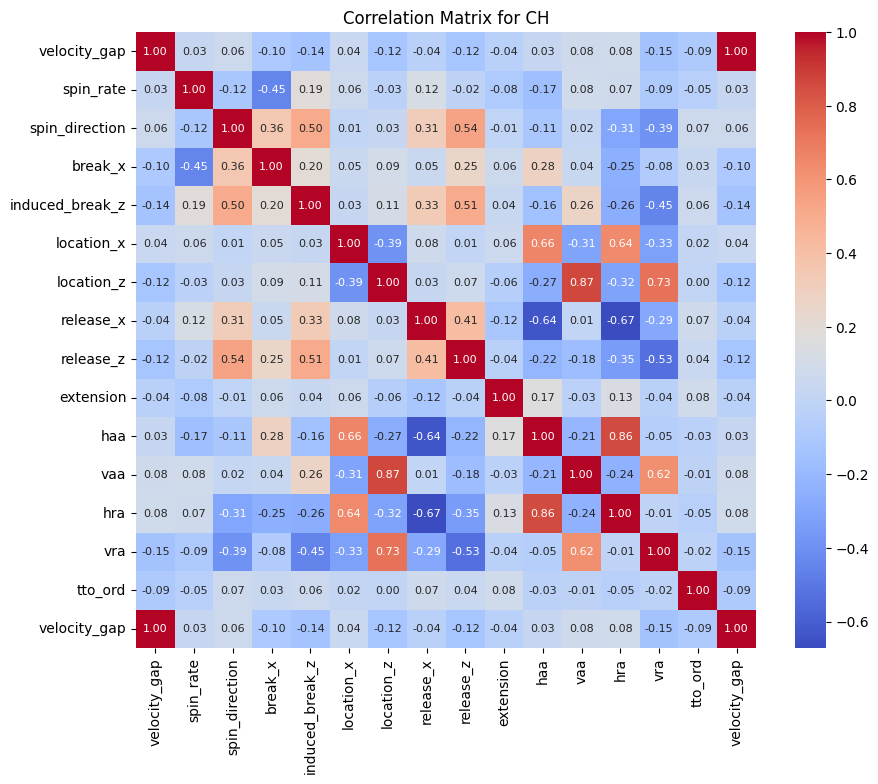

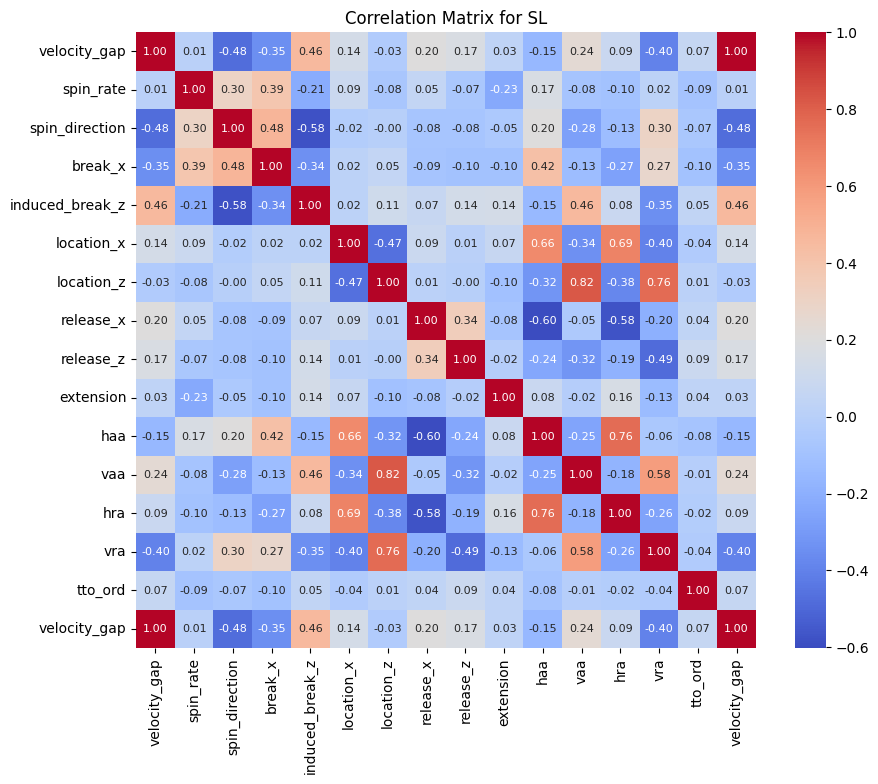

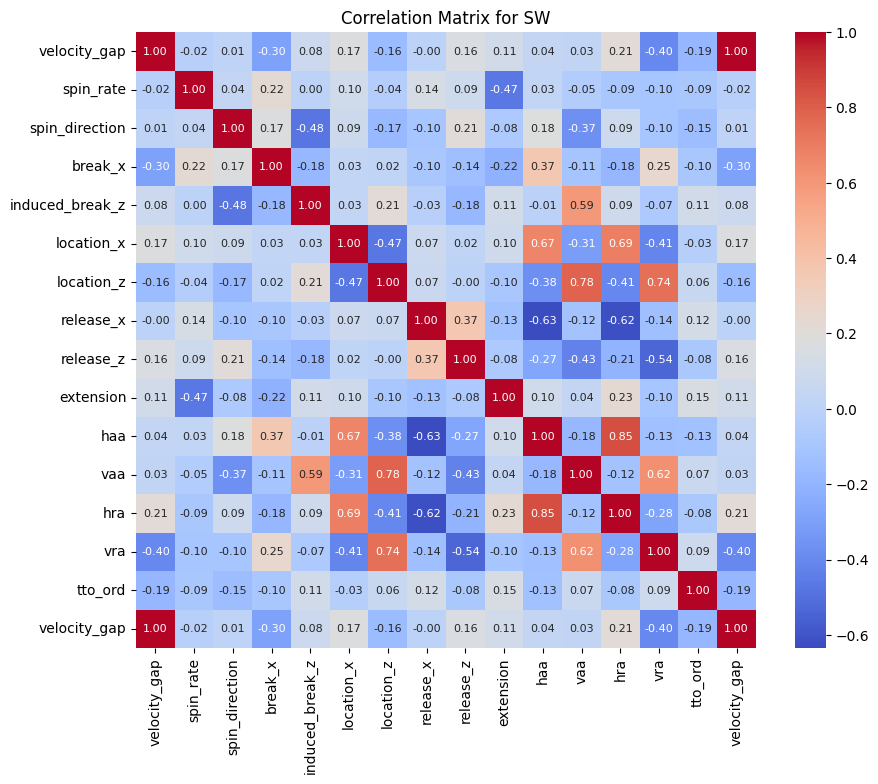

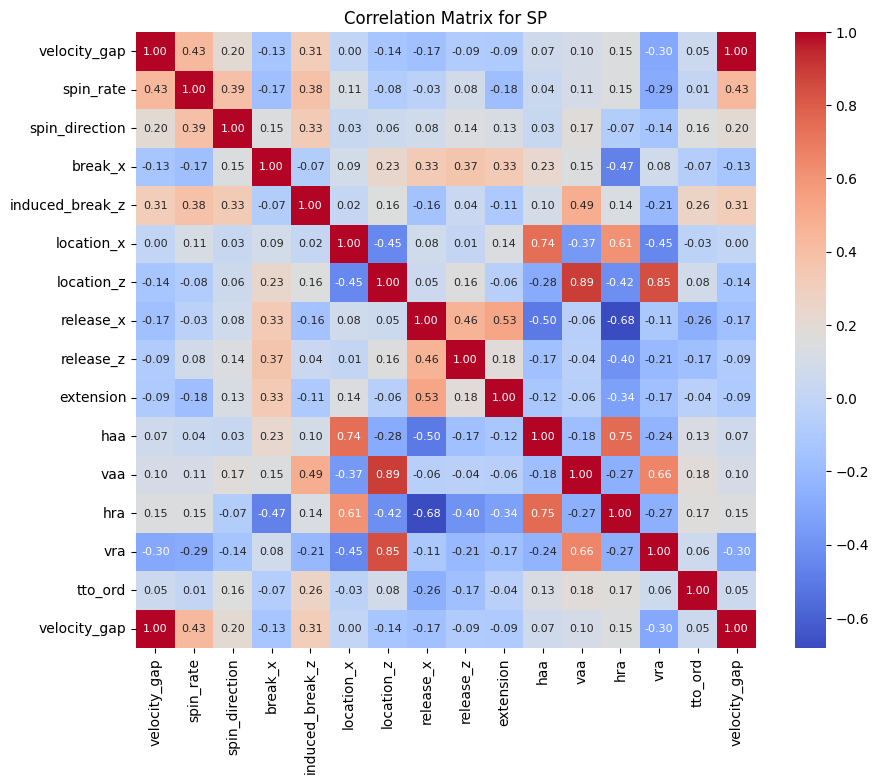

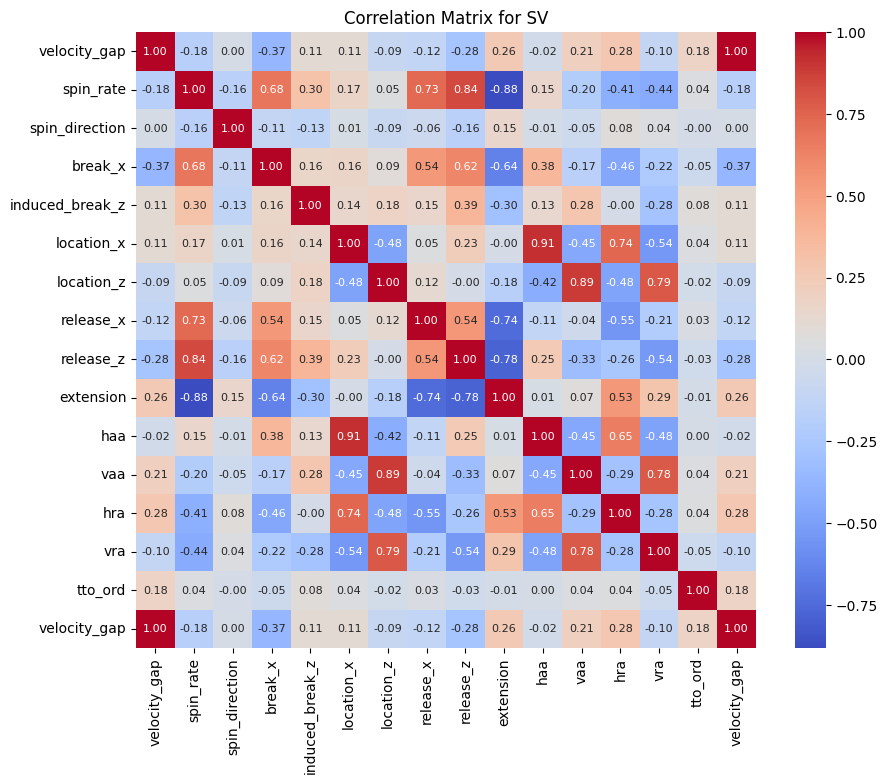

In [16]:
#same thing but for lefties

lefties = df_breaking[df_breaking['throws'] == 'L']

pitch_types = lefties['pitch_type'].unique()

feature_cols = ['velocity_gap', 'spin_rate', 'spin_direction', 'break_x', 'induced_break_z', 'location_x',
                'location_z', 'release_x', 'release_z', 'extension', 'haa', 'vaa', 'hra',
                'vra', 'tto_ord']

for pitch in pitch_types:
    subset = lefties[lefties['pitch_type'] == pitch]
    corr = subset[feature_cols + ['velocity_gap']].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8})
    plt.title(f"Correlation Matrix for {pitch}")
    plt.show()

<ipython-input-17-25657e473c90>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  righties['spin_dir_rad'] = np.deg2rad(righties['spin_direction'])


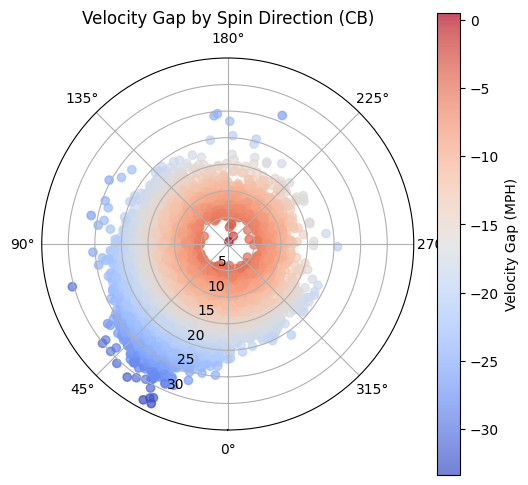

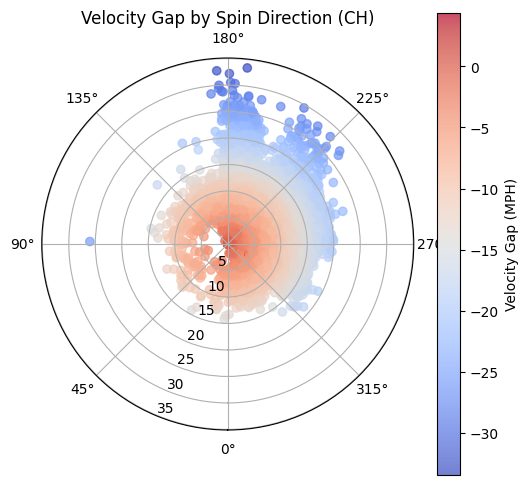

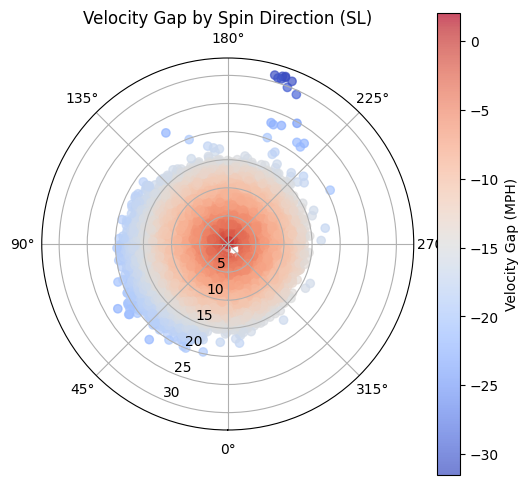

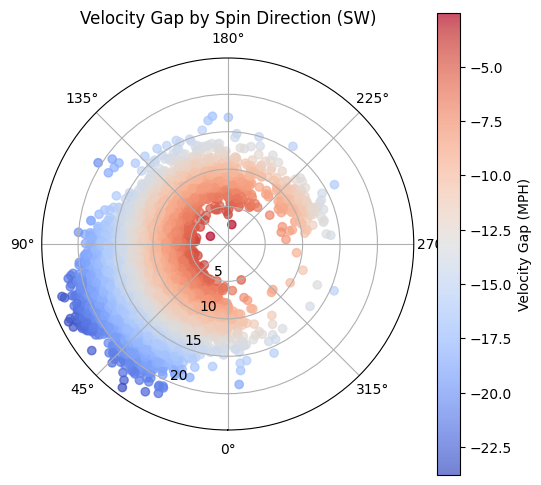

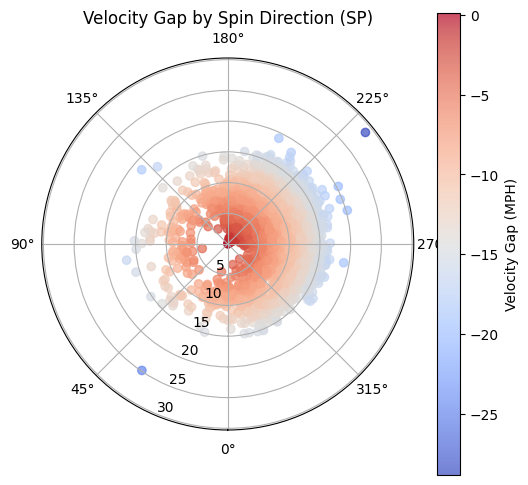

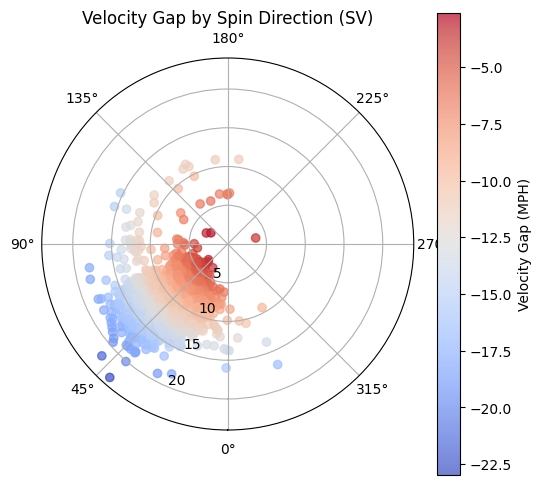

In [17]:
import numpy as np

#Righty spin direction plots

# Convert degrees to radians for plotting
righties['spin_dir_rad'] = np.deg2rad(righties['spin_direction'])


for pitch in pitch_types:
    subset = righties[righties['pitch_type'] == pitch]
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    sc = ax.scatter(subset['spin_dir_rad'],
                np.abs(subset['velocity_gap']),  # or use raw gap
                c=subset['velocity_gap'],
                cmap='coolwarm', alpha=0.7)

    plt.title(f"Velocity Gap by Spin Direction ({pitch})", pad = 25)
    plt.colorbar(sc, label="Velocity Gap (MPH)")
    plt.show()


<ipython-input-18-7e9754872c9b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lefties['spin_dir_rad'] = np.deg2rad(lefties['spin_direction'])


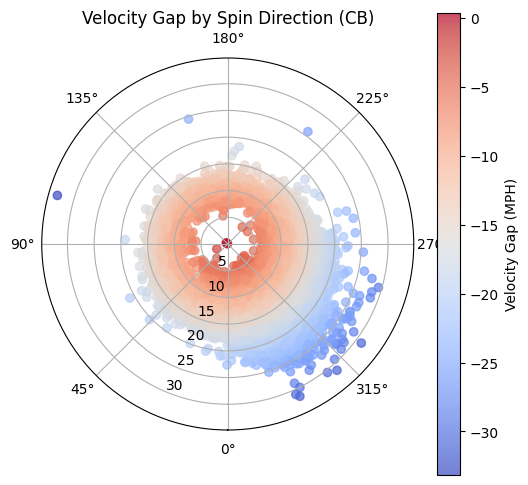

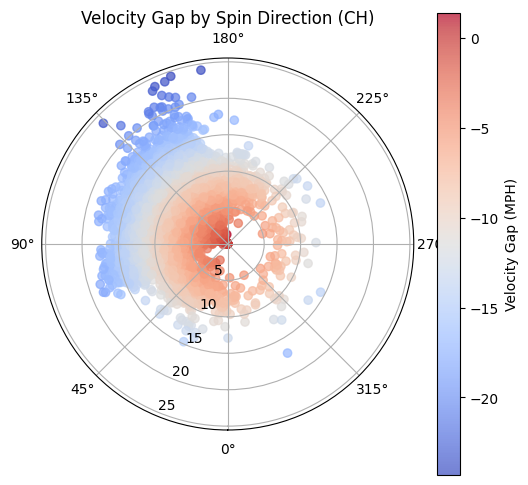

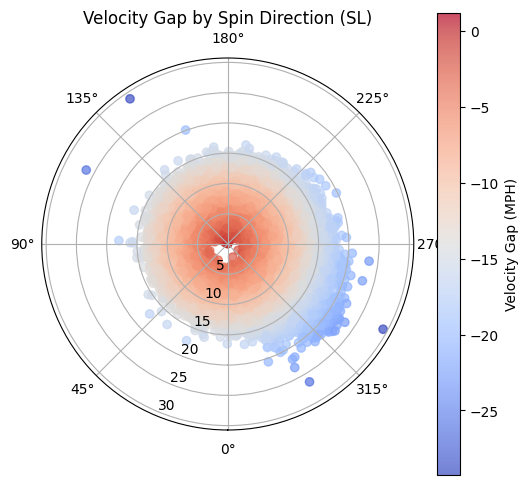

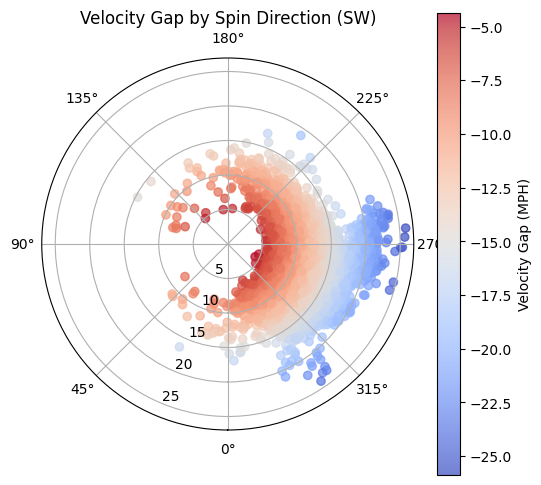

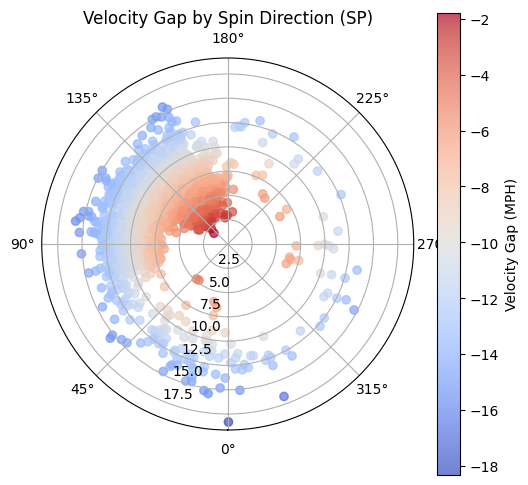

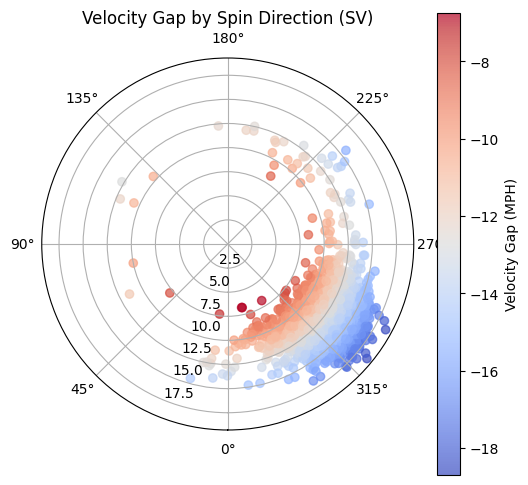

In [18]:
import numpy as np

# Lefty spin direction plots

# Convert degrees to radians for plotting
lefties['spin_dir_rad'] = np.deg2rad(lefties['spin_direction'])


for pitch in pitch_types:
    subset = lefties[lefties['pitch_type'] == pitch]
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    sc = ax.scatter(subset['spin_dir_rad'],
                np.abs(subset['velocity_gap']),  # or use raw gap
                c=subset['velocity_gap'],
                cmap='coolwarm', alpha=0.7)

    plt.title(f"Velocity Gap by Spin Direction ({pitch})", pad = 25)
    plt.colorbar(sc, label="Velocity Gap (MPH)")
    plt.show()


Spin direction had moderate positive correlation with velocity gap on RH sliders and moderate negative correlation on LH sliders. On the polar mapping we see that this means sliders with orientations towards a pitchers **armside** would generally be harder offerings than their counterparts. Spin direction is very finicky though and has no predictive power for some pitches like Sweeper and Slurve.

VAA and HAA being affected heavily by release and location makes a lot of sense.

Horizontal and vertical break are important predictors, as smaller breaking balls are generally harder.

Vertical release angles play a role because harder breaking balls can be thrown with lower VRA, I think similarily smaller, harder breaking horizontal pitches can be thrown closer to the center of the plate and less to the extremes.

Times through the order was a poor predictor across most pitches


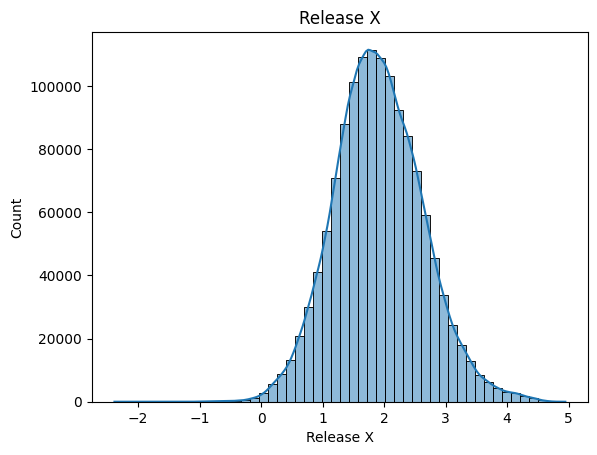

In [19]:
# Normalize horizontal measures by flipping sign for lefties
for col in ['break_x', 'release_x', 'haa', 'hra']:
    df_breaking[f'norm_{col}'] = df_breaking.apply(
        lambda row: -row[col] if row['throws'] == 'L' else row[col],
        axis=1
    )

sns.histplot(df_breaking['norm_release_x'], bins=50, kde=True)
plt.title("Release X")
plt.xlabel("Release X")
plt.show()

         game_id        date  season  batter_id         batter bats  \
2305285   633015  2021-08-05    2021     595956  Cam Gallagher    R   

         pitcher_id          pitcher throws  inning half_inning  tto  \
2305285      676979  Garrett Crochet      L       9         Top  1st   

         pitch_num  balls  strikes  outs pitch_type  release_velo  spin_rate  \
2305285          3      0        2     1         CH       93.0302  2078.5069   

         spin_direction  break_x  break_z  induced_break_z  location_x  \
2305285        140.5555 -26.3497  19.6821          45.6978     -1.3595   

         location_z  release_x  release_z  extension     haa     vaa     hra  \
2305285      6.0217    -1.4312     6.2058     6.8242 -2.0531  1.3916  2.4842   

            vra  exit_velo  launch_angle  spray_angle  hit_spin_rate  \
2305285 -1.9991        NaN           NaN          NaN            NaN   

         avg_fastball_velocity primary_fastball_type  velocity_gap  tto_ord  \
2305285          

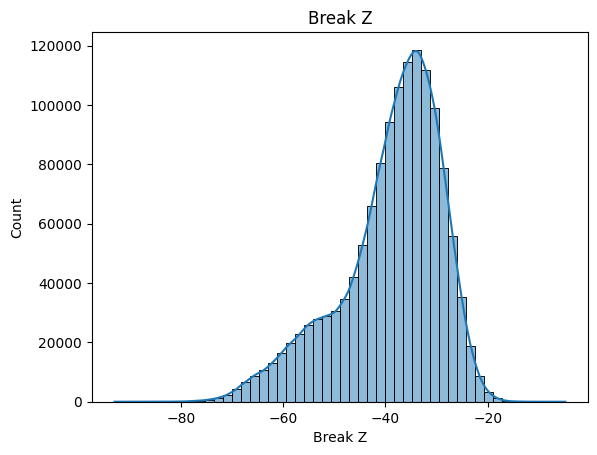

In [20]:
#likely a misread, with gravity all regular break should be negative

print(df_breaking[df_breaking['break_z'] > 0])

df_breaking = df_breaking[df_breaking['break_z'] <= 0]

sns.histplot(df_breaking['break_z'], bins=50, kde=True)
plt.title("Break Z")
plt.xlabel("Break Z")
plt.show()

I want to make the model handedness blind because I worry about the inefficiency of asking it to identify the pattern of movements and angles from different handed throwers by itself. I'm choosing to normalize the horizontal characteristics of pitch movement and release so righties and lefties can be viewed on the same scale.

In [21]:
df_breaking['spin_dir_rad'] = np.deg2rad(df_breaking['spin_direction'])

# Add sine and cosine for model to easily understand
df_breaking['spin_sin'] = np.sin(df_breaking['spin_dir_rad'])
df_breaking['spin_cos'] = np.cos(df_breaking['spin_dir_rad'])

df_breaking

X = df_breaking[['spin_rate', 'pitch_type', 'break_z', 'release_z', 'vaa', 'vra',
                'avg_fastball_velocity', 'norm_break_x', 'norm_release_x', 'norm_haa',
                'norm_hra', 'spin_sin', 'spin_cos']]

Y = df_breaking['velocity_gap']


X = pd.get_dummies(X, columns=['pitch_type'], drop_first=True)

pitch_type_columns = [col for col in X.columns if 'pitch_type' in col]
X[pitch_type_columns] = X[pitch_type_columns].astype(int)

print(X)

print(Y)

         spin_rate  break_z  release_z      vaa     vra  \
0        2403.1722 -45.5579     5.9136 -10.4744 -1.9942   
2        2259.2908 -33.2313     6.6116  -9.1573 -2.9818   
3        2120.8318 -35.8221     5.8143  -6.2436  0.5503   
4        2157.9990 -31.8588     5.5856  -7.8794 -1.9651   
5        2195.1963 -42.0941     6.3631  -8.4697 -0.6046   
...            ...      ...        ...      ...     ...   
3104886  2874.1629 -35.9505     5.1947  -6.7947 -0.0542   
3104887  3005.5961 -33.1564     5.4070  -6.1788 -0.0052   
3104888  2834.9999 -35.5593     5.3855  -6.9210 -0.2912   
3104889  1889.7062 -36.0079     2.8854  -2.5742  4.2273   
3104890  2385.0485 -41.6825     5.9656  -7.2706  0.5677   

         avg_fastball_velocity  norm_break_x  norm_release_x  norm_haa  \
0                    96.002728        1.0821          1.4551   -2.8782   
2                    95.197707       -0.7406          1.0864   -1.5109   
3                    93.501114       16.2299          2.0395   -1.440

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=50)

I want to try simple linear regression to see if it can perform well despite some categorical features and non linear patterns from spin direction. I expect my random forest models will better handle non linearity and perform better at slightly higher computational cost

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

# Evaluation
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Linear Regression R²: {r2:.2f}")

Linear Regression RMSE: 3.98
Linear Regression R²: 0.68


In [25]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)

                  Feature  Coefficient
6            norm_break_x    21.980139
8                norm_haa   -18.579328
9                norm_hra    13.193805
1                 break_z     4.934929
3                     vaa    -1.997281
4                     vra     1.402112
5   avg_fastball_velocity    -0.881315
12          pitch_type_CH    -0.657997
0               spin_rate     0.490204
14          pitch_type_SL     0.249143
17          pitch_type_SW    -0.201942
2               release_z    -0.185781
7          norm_release_x    -0.168231
10               spin_sin    -0.125164
11               spin_cos     0.107694
16          pitch_type_SV     0.050296
15          pitch_type_SP    -0.019326
13          pitch_type_KN    -0.008070


Linear Regression produced solid results, we see that the RMSE was less than 4 mph on the velocity gap and it had an R^2 value of .68. It's also nice to easily see and interpret which features are most important for these predictions. Norm_break_x has such a positive relationship with velocity gap because larger glove side pitches end up slower than pitches with smaller amounts of gloveside movement. In short, the linear regression gave an easily interpretable and fairly accurate model as a starting point. It seemed to understandably struggle at using the sin and cosine of spin direction. Let's use more complex non-linear models to see how high we can boost our accuracy.

In [26]:
from lightgbm import LGBMRegressor

boosted_lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=50,
    n_jobs=-1
)

boosted_lgb.fit(X_train, y_train)
lgb_y_pred = boosted_lgb.predict(X_test)

rmse = mean_squared_error(y_test, lgb_y_pred)
r2 = r2_score(y_test, lgb_y_pred)

print(f"Boosted LightGBM RMSE: {rmse:.2f}")
print(f"Boosted LightGBM R²: {r2:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3072
[LightGBM] [Info] Number of data points in the train set: 1074121, number of used features: 18
[LightGBM] [Info] Start training from score -10.057408
Boosted LightGBM RMSE: 2.30
Boosted LightGBM R²: 0.82


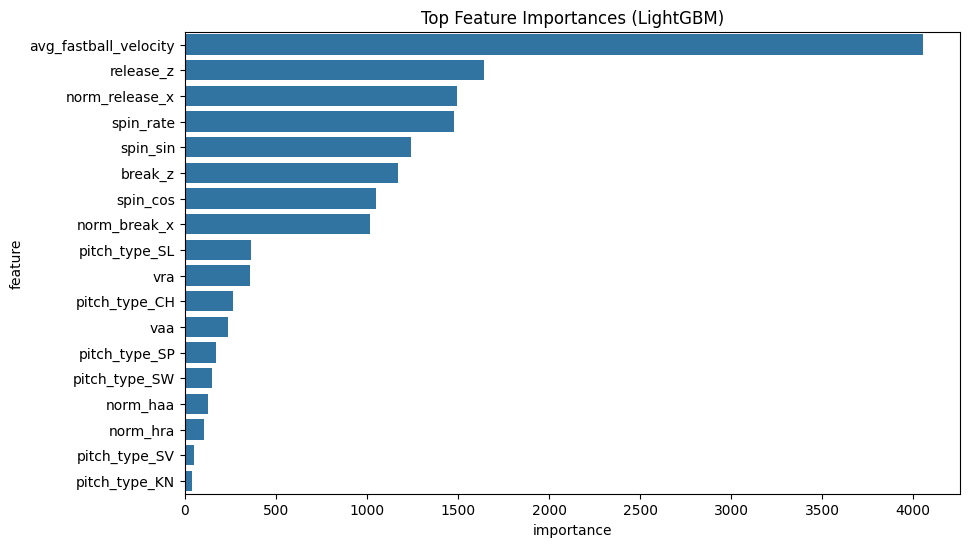

In [27]:
#visualizing the most important features

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': boosted_lgb.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title("Top Feature Importances (LightGBM)")
plt.show()

In [28]:
#final predictions

pred_df = pd.DataFrame(lgb_y_pred, columns=['predicted_velocity_gap'], index=X_test.index)

X_test_with_preds = X_test.copy()
X_test_with_preds['predicted_velocity_gap'] = pred_df


X_test_with_preds['actual_velocity_gap'] = y_test

X_test_with_preds

spin_rate  break_z  release_z      vaa     vra  \
2202740  2869.9585 -47.4799     6.2790  -9.1299 -0.3165   
1741591  2584.6216 -57.4000     5.2522 -10.1935  0.7144   
1866583  2663.4525 -32.9994     5.1540  -7.3348 -1.1513   
1856641  2137.0623 -29.8228     5.7240  -6.4436 -0.8120   
1407089  2312.3481 -30.1773     6.7984  -8.4361 -2.8068   
...            ...      ...        ...      ...     ...   
2113491  2298.4540 -54.4727     5.1767  -8.3387  1.9427   
667704   2090.9838 -26.3021     5.9886  -7.5745 -2.6605   
642957   1446.1927 -27.1218     5.8833  -6.2548 -1.1169   
2386643  2278.4611 -62.7341     6.7384 -10.5948  1.2938   
943341   2426.3068 -56.7646     6.0469 -10.4622  0.2345   

         avg_fastball_velocity  norm_break_x  norm_release_x  norm_haa  \
2202740              93.434242       -8.8374          2.6063   -4.1902   
1741591              92.909695      -16.9878          1.9672   -4.1944   
1866583              90.090349       -2.8976          0.7386   -2.2373   
1856641              95.865537       16.1715          0.6811    1.9834   
1407089              95.831082       -2.3216          2.1550   -3.3916   
...                        ...           ...             ...       ...   
2113491              92.909695      -14.1627          1.9447   -3.2099   
667704               93.396712       -1.2582          2.5095   -4.2840   
642957               93.450501       13.4386          0.8051   -0.0304   
2386643              95.144304      -10.3490          1.9258   -2.0313   
943341               93.383397       -9.1019          2.7225   -4.7108   

         norm_hra  spin_sin  spin_cos  pitch_type_CH  pitch_type_KN  \
2202740   -2.5363  0.779482  0.626424              0              0   
1741591   -0.9332  0.776306  0.630356              0              0   
1866583   -1.6909  0.196057 -0.980592              0              0   
1856641   -1.0865  0.820763 -0.571270              1              0   
1407089   -2.9538 -0.202681 -0.979245              0              0   
...           ...       ...       ...            ...            ...   
2113491   -0.5210  0.814632  0.579978              0              0   
667704    -4.0468  0.391019 -0.920383              0              0   
642957    -2.5873 -0.846663 -0.532129              1              0   
2386643   -0.0496 -0.382903  0.923789              0              0   
943341    -2.9790  0.594680  0.803963              0              0   

         pitch_type_SL  pitch_type_SP  pitch_type_SV  pitch_type_SW  \
2202740              1              0              0              0   
1741591              0              0              0              0   
1866583              1              0              0              0   
1856641              0              0              0              0   
1407089              1              0              0              0   
...                ...            ...            ...            ...   
2113491              0              0              0              0   
667704               1              0              0              0   
642957               0              0              0              0   
2386643              0              0              0              0   
943341               0              0              0              0   

         predicted_velocity_gap  actual_velocity_gap  
2202740              -10.783053           -12.333942  
1741591              -15.171063           -15.355495  
1866583               -3.726685            -3.667749  
1856641               -7.652440            -8.247737  
1407089               -7.503880            -7.500382  
...                         ...                  ...  
2113491              -15.945609           -14.364395  
667704                -5.412379            -3.834512  
642957                -7.340141            -5.968101  
2386643              -18.945705           -19.425104  
943341               -14.314251           -13.669397  

[268531 rows x 20 columns]

# Final Write Up

## Data Exploration and Cleaning
The starting data was just over 3 million entries with 36 variables to use. Most NAs that appeared were from batted ball chracteristics which weren't going to be used in this analysis so there was no need to drop these rows. Other NAs that were dropped made up a very small portions of the dataset. These inclued misreads from the collection system or non competitive pitch types. There was an intial spilt in the dataset to allow for grouping and defining primary fastballs apart from a pitcher's off speed offerings. Grouping primary fastballs (FF, SI, CT, included because of pitchers like Clase and Duval) allowed for a quick calculation of average primary fastball velocity for a season and this was used to create the taget variable of 'velocity_gap', by subtracting a breaking pitch's release velo by the avg_fastball_velocity.

Additionally, features had to be transformed and properly encoded for later machine learning models. Pitch_type used one hot encoding to retain the labeling of the pitch in a means by which the model could understand. Spin direction showed promise as a predictive variable so the degrees measurement that was 0-360 was changed to radians and the cosine and sine functions so models could more easily understand the measurements from -1 to 1.

## Feature Selection
I wanted the model to focus a lot on the chracteristics of the pitch and it's release rather than the enviromental context of the game around the pitch. I didn't want to risk certain models trying to 'predict' the pitch being thrown based on count and game situation, so these variables weren't used in my models. I made sure when using correlation analysis to bucket off by pitch types and pitcher handedness so as to not muddy trends with unecessary generalization. RH sliders and their patterns should not have influence over LH curveball. These pitch's will have large varying horizontal and vertical data points. It was clear vertical break and VAA were very strong predictors due to their ability to describe the shape of pitches, and they were very strong performers across all models. Additionally, the horizontal components of pitch release were normalized so as to not risk the model being unable to discern the difference in RH vs LH pitch type patterns. The final list of features selected to predict the velocity gap were:

*   Spin Rate
*   Spin Orientation (represented as Sin and Cosine)
*   Vertical Break
*   Vertical Release Point
*   Vertical Approach Angle
*   Vertical Release Angle
*   A pitcher's Average Primary Fastball Velocity across a season
*   Normalized Horizontal Break across handedness
*   Normalized Horizontal Release across handedness
*   Normalized Horizontal Approach Angle across handedness
*   Normalized Horizontal Release Point across handedness
*   Type of Pitch thrown (represented with one hot encoding)


## Model Training and Performance

I wanted to use a linear model for easy interpretability and computational ease of use with the larger dataset. Even though spin direction and pitch type patterns were non linear, strong predictors like vertical break were and I wanted to see if a very simple and easily interpretable model could perform well.

The linear regression performed better than I expected. It returned a RMSE of just under 4 at 3.98 and an R squared value of 0.68. This was not bad considering it's ease on computation and interpretability. I still wanted to use a non-linear model to capture some of the patterns found in spin direction especially. I decided on using LightGBM due to it's speed at handling larger datasets compared to it's peers.

LightGBM returned great results and was able to finish running in under a minute. The RMSE for the LightGBM model was 2.3 and the R squared value was .82. Average fastball velocity was the most important variable by far in the LightGBM model, which is more intuitive than the low level of prediction in the linear model. This is probably due to the boosting methodology of the GBM model learning over those multiple iterations about the relationship between fastball velocity and velocity gap, whereas the linear model wouldn't have iterations to learn this trend over periods of trial and error. I'm also happy to see the spin direction measurements proved to be valuable contributors to the model due to their predictive power with certain pitches.



## Final Considerations

If given the ability to I would like to revisit this project in the future to work on these criteria:



*   Getting Position tags so I could make sure position player pitching would be successfully removed from the data without touching actual pitches. I used different velocity cutoffs to get rid of the vast majority of position player pitching, but it would be nice to have definitive measures by which to exclude them without risking removing a pitch from an actual pitcher.
*   Going more in depth and creating models per pitch type, capturing intra pitch relationships better.
*   Model Stacking or Ensembling could be used to bring the best of both worlds for models that work great for non-linear trends like spin direction while having linear models for linear predictors like break.
*   Hyperparametrization to continue to improve upon model performance.
*   Evaluate model performance across year to year changes. As pitcher's continue to experiment with pitch shapes like the new sweeper, having continually fresh data to train the model on would be an exciting opportunity.






